In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from tqdm import tqdm

class RollingWindowPredictor:
    def __init__(self, window_size=5):
        """
        Initialize the predictor
        window_size: number of days to use for prediction (default: 5)
        """
        self.window_size = window_size
        self.scaler = StandardScaler()
        self.model = None
        
    def prepare_rolling_window_data(self, df, start_idx, end_idx):
        """
        Prepare data for a single rolling window
        """
        # Get window data
        window_data = df.iloc[start_idx:end_idx]
        
        # Get target (next day)
        if end_idx < len(df):
            target = df.iloc[end_idx]['target']
        else:
            target = None
            
        # Scale the window data
        scaled_data = self.scaler.fit_transform(window_data)
        
        # Flatten the window into a single feature vector
        X = scaled_data.reshape(1, -1)
        
        return X, target

    def objective(self, trial, X_train, y_train, X_val, y_val):
        """Optuna objective for hyperparameter optimization"""
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 0.5)
        }
        
        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            early_stopping_rounds=20
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        preds = model.predict(X_val)
        return mean_squared_error(y_val, preds, squared=False)  # RMSE

    def create_training_windows(self, df, validation_size=0.2):
        """Create training and validation windows"""
        X_list, y_list = [], []
        
        # Calculate the number of possible windows
        n_windows = len(df) - self.window_size
        
        # Create windows
        for i in range(n_windows):
            X, y = self.prepare_rolling_window_data(df, i, i + self.window_size)
            if y is not None:  # Skip if we don't have a target
                X_list.append(X)
                y_list.append(y)
        
        # Convert to numpy arrays
        X = np.vstack(X_list)
        y = np.array(y_list)
        
        # Split into train and validation
        split_idx = int(len(X) * (1 - validation_size))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        
        return X_train, y_train, X_val, y_val

    def train(self, df, n_trials=5):
        """Train the model with hyperparameter optimization"""
        print("Creating training windows...")
        X_train, y_train, X_val, y_val = self.create_training_windows(df)
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        print("\nOptimizing hyperparameters...")
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: self.objective(trial, X_train, y_train, X_val, y_val),
                      n_trials=n_trials)
        
        print("\nBest parameters:", study.best_params)
        
        # Train final model on all data
        self.model = xgb.XGBRegressor(**study.best_params, random_state=42)
        self.model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
        
        return study.best_value

    def predict_next_day(self, window_data):
        """Predict the next day's value given a window of data"""
        X, _ = self.prepare_rolling_window_data(window_data, 0, len(window_data))
        return self.model.predict(X)[0]

    def backtest(self, df, start_date=None):
        """
        Perform backtesting on the data
        Returns predictions and actual values
        """
        predictions = []
        actuals = []
        dates = []
        
        # If no start_date is provided, use the first possible date for prediction
        if start_date is None:
            start_idx = self.window_size
        else:
            start_idx = df.index.get_loc(start_date)
            
        # Iterate through the data
        for i in tqdm(range(start_idx, len(df)), desc="Backtesting"):
            # Get window data
            window_data = df.iloc[i - self.window_size:i]
            
            print("predict",df.index[i])

            # Make prediction
            pred = self.predict_next_day(window_data)
            actual = df.iloc[i]['target']
            
            predictions.append(pred)
            actuals.append(actual)
            dates.append(df.index[i])
            
        return pd.DataFrame({
            'date': dates,
            'predicted': predictions,
            'actual': actuals
        }).set_index('date')

    def evaluate(self, df, start_date=None, show_plots=True):
        """Evaluate model performance"""
        results = self.backtest(df, start_date)
        
        # Calculate metrics
        rmse = mean_squared_error(results['actual'], results['predicted'], squared=False)
        mae = mean_absolute_error(results['actual'], results['predicted'])
        r2 = r2_score(results['actual'], results['predicted'])
        
        print("\nPerformance Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2 Score: {r2:.4f}")
        
        if show_plots:
            # Plot predictions vs actual over time
            plt.figure(figsize=(15, 6))
            plt.plot(results.index, results['actual'], label='Actual', alpha=0.7)
            plt.plot(results.index, results['predicted'], label='Predicted', alpha=0.7)
            plt.title('Predictions vs Actual Over Time')
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Plot actual vs predicted scatter
            plt.figure(figsize=(10, 6))
            plt.scatter(results['actual'], results['predicted'], alpha=0.5)
            plt.plot([results['actual'].min(), results['actual'].max()], 
                    [results['actual'].min(), results['actual'].max()], 
                    'r--', lw=2)
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('Actual vs Predicted Values')
            plt.show()
            
            # Plot prediction error distribution
            plt.figure(figsize=(10, 6))
            errors = results['predicted'] - results['actual']
            plt.hist(errors, bins=50)
            plt.title('Prediction Error Distribution')
            plt.xlabel('Prediction Error')
            plt.ylabel('Frequency')
            plt.show()
        
        return results



Training model...
Creating training windows...


[I 2024-11-05 11:46:20,270] A new study created in memory with name: no-name-01e94b0b-5d18-4dd3-ad5b-240dbe49b018


Training data shape: (3672, 395)
Validation data shape: (919, 395)

Optimizing hyperparameters...


[I 2024-11-05 11:46:35,613] Trial 0 finished with value: 0.20054115554729482 and parameters: {'max_depth': 8, 'learning_rate': 0.0185265442827746, 'n_estimators': 206, 'min_child_weight': 1, 'subsample': 0.7830545640287101, 'colsample_bytree': 0.8038338174725567, 'gamma': 0.31435633100878835}. Best is trial 0 with value: 0.20054115554729482.
[I 2024-11-05 11:46:38,087] Trial 1 finished with value: 0.2092700697102592 and parameters: {'max_depth': 4, 'learning_rate': 0.027416521492297542, 'n_estimators': 53, 'min_child_weight': 3, 'subsample': 0.6366850500365776, 'colsample_bytree': 0.6524359142370433, 'gamma': 0.013236111973150833}. Best is trial 0 with value: 0.20054115554729482.
[I 2024-11-05 11:46:39,898] Trial 2 finished with value: 0.20442254253750158 and parameters: {'max_depth': 3, 'learning_rate': 0.047482489823538844, 'n_estimators': 55, 'min_child_weight': 6, 'subsample': 0.9461853382234253, 'colsample_bytree': 0.7631342430183345, 'gamma': 0.28980729658151144}. Best is trial 0


Best parameters: {'max_depth': 8, 'learning_rate': 0.0185265442827746, 'n_estimators': 206, 'min_child_weight': 1, 'subsample': 0.7830545640287101, 'colsample_bytree': 0.8038338174725567, 'gamma': 0.31435633100878835}

Best validation RMSE: 0.2005

Performing backtest on test set...


Backtesting:   1%|          | 6/1145 [00:00<00:20, 56.15it/s]

predict 2024-05-02 14:45:00
predict 2024-05-03 08:30:00
predict 2024-05-03 08:45:00
predict 2024-05-03 09:00:00
predict 2024-05-03 09:15:00
predict 2024-05-03 09:30:00
predict 2024-05-03 09:45:00
predict 2024-05-03 10:00:00
predict 2024-05-03 10:15:00
predict 2024-05-03 10:30:00
predict 2024-05-03 10:45:00
predict 2024-05-03 11:00:00


Backtesting:   1%|          | 12/1145 [00:00<00:20, 56.35it/s]

predict 2024-05-03 11:15:00


Backtesting:   2%|▏         | 18/1145 [00:00<00:19, 56.75it/s]

predict 2024-05-03 11:30:00
predict 2024-05-03 11:45:00
predict 2024-05-03 12:00:00
predict 2024-05-03 12:15:00
predict 2024-05-03 12:30:00
predict 2024-05-03 12:45:00
predict 2024-05-03 13:00:00
predict 2024-05-03 13:15:00
predict 2024-05-03 13:30:00
predict 2024-05-03 13:45:00
predict 2024-05-03 14:00:00


Backtesting:   2%|▏         | 24/1145 [00:00<00:19, 56.09it/s]

predict 2024-05-03 14:15:00


Backtesting:   3%|▎         | 36/1145 [00:00<00:19, 55.66it/s]

predict 2024-05-03 14:30:00
predict 2024-05-03 14:45:00
predict 2024-05-06 08:30:00
predict 2024-05-06 08:45:00
predict 2024-05-06 09:00:00
predict 2024-05-06 09:15:00
predict 2024-05-06 09:30:00
predict 2024-05-06 09:45:00
predict 2024-05-06 10:00:00
predict 2024-05-06 10:15:00
predict 2024-05-06 10:30:00
predict 2024-05-06 10:45:00


Backtesting:   4%|▎         | 42/1145 [00:00<00:20, 54.21it/s]

predict 2024-05-06 11:00:00
predict 2024-05-06 11:15:00
predict 2024-05-06 11:30:00
predict 2024-05-06 11:45:00
predict 2024-05-06 12:00:00
predict 2024-05-06 12:15:00
predict 2024-05-06 12:30:00
predict 2024-05-06 12:45:00
predict 2024-05-06 13:00:00


Backtesting:   5%|▍         | 53/1145 [00:01<00:25, 42.09it/s]

predict 2024-05-06 13:15:00
predict 2024-05-06 13:30:00
predict 2024-05-06 13:45:00
predict 2024-05-06 14:00:00
predict 2024-05-06 14:15:00
predict 2024-05-06 14:30:00
predict 2024-05-06 14:45:00
predict 2024-05-07 08:30:00


Backtesting:   6%|▌         | 65/1145 [00:01<00:22, 48.74it/s]

predict 2024-05-07 08:45:00
predict 2024-05-07 09:00:00
predict 2024-05-07 09:15:00
predict 2024-05-07 09:30:00
predict 2024-05-07 09:45:00
predict 2024-05-07 10:00:00
predict 2024-05-07 10:15:00
predict 2024-05-07 10:30:00
predict 2024-05-07 10:45:00
predict 2024-05-07 11:00:00
predict 2024-05-07 11:15:00
predict 2024-05-07 11:30:00


Backtesting:   7%|▋         | 77/1145 [00:01<00:20, 52.19it/s]

predict 2024-05-07 11:45:00
predict 2024-05-07 12:00:00
predict 2024-05-07 12:15:00
predict 2024-05-07 12:30:00
predict 2024-05-07 12:45:00
predict 2024-05-07 13:00:00
predict 2024-05-07 13:15:00
predict 2024-05-07 13:30:00
predict 2024-05-07 13:45:00
predict 2024-05-07 14:00:00
predict 2024-05-07 14:15:00
predict 2024-05-07 14:30:00


Backtesting:   8%|▊         | 89/1145 [00:01<00:19, 54.76it/s]

predict 2024-05-07 14:45:00
predict 2024-05-08 08:30:00
predict 2024-05-08 08:45:00
predict 2024-05-08 09:00:00
predict 2024-05-08 09:15:00
predict 2024-05-08 09:30:00
predict 2024-05-08 09:45:00
predict 2024-05-08 10:00:00
predict 2024-05-08 10:15:00
predict 2024-05-08 10:30:00
predict 2024-05-08 10:45:00
predict 2024-05-08 11:00:00
predict 2024-05-08 11:15:00


Backtesting:   8%|▊         | 95/1145 [00:01<00:19, 53.69it/s]

predict 2024-05-08 11:30:00
predict 2024-05-08 11:45:00
predict 2024-05-08 12:00:00
predict 2024-05-08 12:15:00
predict 2024-05-08 12:30:00
predict 2024-05-08 12:45:00
predict 2024-05-08 13:00:00
predict 2024-05-08 13:15:00
predict 2024-05-08 13:30:00
predict 2024-05-08 13:45:00


Backtesting:   9%|▉         | 107/1145 [00:02<00:21, 49.26it/s]

predict 2024-05-08 14:00:00
predict 2024-05-08 14:15:00
predict 2024-05-08 14:30:00
predict 2024-05-08 14:45:00
predict 2024-05-09 08:30:00
predict 2024-05-09 08:45:00
predict 2024-05-09 09:00:00
predict 2024-05-09 09:15:00
predict 2024-05-09 09:30:00
predict 2024-05-09 09:45:00
predict 2024-05-09 10:00:00


Backtesting:  10%|█         | 118/1145 [00:02<00:21, 48.65it/s]

predict 2024-05-09 10:15:00
predict 2024-05-09 10:30:00
predict 2024-05-09 10:45:00
predict 2024-05-09 11:00:00
predict 2024-05-09 11:15:00
predict 2024-05-09 11:30:00
predict 2024-05-09 11:45:00
predict 2024-05-09 12:00:00
predict 2024-05-09 12:15:00
predict 2024-05-09 12:30:00
predict 2024-05-09 12:45:00
predict 2024-05-09 13:00:00


Backtesting:  12%|█▏        | 136/1145 [00:02<00:18, 54.09it/s]

predict 2024-05-09 13:15:00
predict 2024-05-09 13:30:00
predict 2024-05-09 13:45:00
predict 2024-05-09 14:00:00
predict 2024-05-09 14:15:00
predict 2024-05-09 14:30:00
predict 2024-05-09 14:45:00
predict 2024-05-10 08:30:00
predict 2024-05-10 08:45:00
predict 2024-05-10 09:00:00
predict 2024-05-10 09:15:00
predict 2024-05-10 09:30:00
predict 2024-05-10 09:45:00


Backtesting:  13%|█▎        | 148/1145 [00:02<00:17, 55.45it/s]

predict 2024-05-10 10:00:00
predict 2024-05-10 10:15:00
predict 2024-05-10 10:30:00
predict 2024-05-10 10:45:00
predict 2024-05-10 11:00:00
predict 2024-05-10 11:15:00
predict 2024-05-10 11:30:00
predict 2024-05-10 11:45:00
predict 2024-05-10 12:00:00
predict 2024-05-10 12:15:00
predict 2024-05-10 12:30:00
predict 2024-05-10 12:45:00
predict 2024-05-10 13:00:00


Backtesting:  14%|█▍        | 160/1145 [00:03<00:18, 54.03it/s]

predict 2024-05-10 13:15:00
predict 2024-05-10 13:30:00
predict 2024-05-10 13:45:00
predict 2024-05-10 14:00:00
predict 2024-05-10 14:15:00
predict 2024-05-10 14:30:00
predict 2024-05-10 14:45:00
predict 2024-05-13 08:30:00
predict 2024-05-13 08:45:00
predict 2024-05-13 09:00:00
predict 2024-05-13 09:15:00


Backtesting:  15%|█▌        | 172/1145 [00:03<00:17, 55.32it/s]

predict 2024-05-13 09:30:00
predict 2024-05-13 09:45:00
predict 2024-05-13 10:00:00
predict 2024-05-13 10:15:00
predict 2024-05-13 10:30:00
predict 2024-05-13 10:45:00
predict 2024-05-13 11:00:00
predict 2024-05-13 11:15:00
predict 2024-05-13 11:30:00
predict 2024-05-13 11:45:00
predict 2024-05-13 12:00:00
predict 2024-05-13 12:15:00


Backtesting:  16%|█▌        | 184/1145 [00:03<00:16, 56.97it/s]

predict 2024-05-13 12:30:00
predict 2024-05-13 12:45:00
predict 2024-05-13 13:00:00
predict 2024-05-13 13:15:00
predict 2024-05-13 13:30:00
predict 2024-05-13 13:45:00
predict 2024-05-13 14:00:00
predict 2024-05-13 14:15:00
predict 2024-05-13 14:30:00
predict 2024-05-13 14:45:00
predict 2024-05-14 08:30:00
predict 2024-05-14 08:45:00
predict 2024-05-14 09:00:00


Backtesting:  17%|█▋        | 197/1145 [00:03<00:16, 58.32it/s]

predict 2024-05-14 09:15:00
predict 2024-05-14 09:30:00
predict 2024-05-14 09:45:00
predict 2024-05-14 10:00:00
predict 2024-05-14 10:15:00
predict 2024-05-14 10:30:00
predict 2024-05-14 10:45:00
predict 2024-05-14 11:00:00
predict 2024-05-14 11:15:00
predict 2024-05-14 11:30:00
predict 2024-05-14 11:45:00
predict 2024-05-14 12:00:00
predict 2024-05-14 12:15:00


Backtesting:  18%|█▊        | 209/1145 [00:03<00:16, 58.26it/s]

predict 2024-05-14 12:30:00
predict 2024-05-14 12:45:00
predict 2024-05-14 13:00:00
predict 2024-05-14 13:15:00
predict 2024-05-14 13:30:00
predict 2024-05-14 13:45:00
predict 2024-05-14 14:00:00
predict 2024-05-14 14:15:00
predict 2024-05-14 14:30:00
predict 2024-05-14 14:45:00
predict 2024-05-15 08:30:00
predict 2024-05-15 08:45:00
predict 2024-05-15 09:00:00


Backtesting:  19%|█▉        | 221/1145 [00:04<00:15, 58.39it/s]

predict 2024-05-15 09:15:00
predict 2024-05-15 09:30:00
predict 2024-05-15 09:45:00
predict 2024-05-15 10:00:00
predict 2024-05-15 10:15:00
predict 2024-05-15 10:30:00
predict 2024-05-15 10:45:00
predict 2024-05-15 11:00:00
predict 2024-05-15 11:15:00
predict 2024-05-15 11:30:00
predict 2024-05-15 11:45:00
predict 2024-05-15 12:00:00
predict 2024-05-15 12:15:00


Backtesting:  20%|██        | 233/1145 [00:04<00:15, 57.94it/s]

predict 2024-05-15 12:30:00
predict 2024-05-15 12:45:00
predict 2024-05-15 13:00:00
predict 2024-05-15 13:15:00
predict 2024-05-15 13:30:00
predict 2024-05-15 13:45:00
predict 2024-05-15 14:00:00
predict 2024-05-15 14:15:00
predict 2024-05-15 14:30:00
predict 2024-05-15 14:45:00
predict 2024-05-16 08:30:00
predict 2024-05-16 08:45:00


Backtesting:  21%|██▏       | 245/1145 [00:04<00:16, 53.41it/s]

predict 2024-05-16 09:00:00
predict 2024-05-16 09:15:00
predict 2024-05-16 09:30:00
predict 2024-05-16 09:45:00
predict 2024-05-16 10:00:00
predict 2024-05-16 10:15:00
predict 2024-05-16 10:30:00
predict 2024-05-16 10:45:00
predict 2024-05-16 11:00:00
predict 2024-05-16 11:15:00
predict 2024-05-16 11:30:00


Backtesting:  22%|██▏       | 257/1145 [00:04<00:16, 54.64it/s]

predict 2024-05-16 11:45:00
predict 2024-05-16 12:00:00
predict 2024-05-16 12:15:00
predict 2024-05-16 12:30:00
predict 2024-05-16 12:45:00
predict 2024-05-16 13:00:00
predict 2024-05-16 13:15:00
predict 2024-05-16 13:30:00
predict 2024-05-16 13:45:00
predict 2024-05-16 14:00:00
predict 2024-05-16 14:15:00
predict 2024-05-16 14:30:00


Backtesting:  23%|██▎       | 263/1145 [00:04<00:19, 44.11it/s]

predict 2024-05-16 14:45:00
predict 2024-05-17 08:30:00
predict 2024-05-17 08:45:00
predict 2024-05-17 09:00:00
predict 2024-05-17 09:15:00


Backtesting:  24%|██▍       | 273/1145 [00:05<00:19, 44.19it/s]

predict 2024-05-17 09:30:00
predict 2024-05-17 09:45:00
predict 2024-05-17 10:00:00
predict 2024-05-17 10:15:00
predict 2024-05-17 10:30:00
predict 2024-05-17 10:45:00
predict 2024-05-17 11:00:00
predict 2024-05-17 11:15:00
predict 2024-05-17 11:30:00
predict 2024-05-17 11:45:00


Backtesting:  25%|██▍       | 283/1145 [00:05<00:19, 43.73it/s]

predict 2024-05-17 12:00:00
predict 2024-05-17 12:15:00
predict 2024-05-17 12:30:00
predict 2024-05-17 12:45:00
predict 2024-05-17 13:00:00
predict 2024-05-17 13:15:00
predict 2024-05-17 13:30:00
predict 2024-05-17 13:45:00
predict 2024-05-17 14:00:00
predict 2024-05-17 14:15:00


Backtesting:  26%|██▌       | 293/1145 [00:05<00:18, 44.85it/s]

predict 2024-05-17 14:30:00
predict 2024-05-17 14:45:00
predict 2024-05-20 08:30:00
predict 2024-05-20 08:45:00
predict 2024-05-20 09:00:00
predict 2024-05-20 09:15:00
predict 2024-05-20 09:30:00
predict 2024-05-20 09:45:00
predict 2024-05-20 10:00:00
predict 2024-05-20 10:15:00


Backtesting:  27%|██▋       | 304/1145 [00:05<00:17, 47.46it/s]

predict 2024-05-20 10:30:00
predict 2024-05-20 10:45:00
predict 2024-05-20 11:00:00
predict 2024-05-20 11:15:00
predict 2024-05-20 11:30:00
predict 2024-05-20 11:45:00
predict 2024-05-20 12:00:00
predict 2024-05-20 12:15:00
predict 2024-05-20 12:30:00
predict 2024-05-20 12:45:00
predict 2024-05-20 13:00:00


Backtesting:  27%|██▋       | 309/1145 [00:06<00:22, 37.34it/s]

predict 2024-05-20 13:15:00
predict 2024-05-20 13:30:00
predict 2024-05-20 13:45:00
predict 2024-05-20 14:00:00
predict 2024-05-20 14:15:00
predict 2024-05-20 14:30:00


Backtesting:  28%|██▊       | 319/1145 [00:06<00:22, 37.47it/s]

predict 2024-05-20 14:45:00
predict 2024-05-21 08:30:00
predict 2024-05-21 08:45:00
predict 2024-05-21 09:00:00
predict 2024-05-21 09:15:00
predict 2024-05-21 09:30:00
predict 2024-05-21 09:45:00


Backtesting:  28%|██▊       | 323/1145 [00:06<00:22, 35.78it/s]

predict 2024-05-21 10:00:00
predict 2024-05-21 10:15:00
predict 2024-05-21 10:30:00
predict 2024-05-21 10:45:00
predict 2024-05-21 11:00:00
predict 2024-05-21 11:15:00
predict 2024-05-21 11:30:00


Backtesting:  29%|██▊       | 327/1145 [00:06<00:25, 31.73it/s]

predict 2024-05-21 11:45:00
predict 2024-05-21 12:00:00
predict 2024-05-21 12:15:00
predict 2024-05-21 12:30:00


Backtesting:  29%|██▉       | 334/1145 [00:07<00:31, 25.49it/s]

predict 2024-05-21 12:45:00
predict 2024-05-21 13:00:00
predict 2024-05-21 13:15:00
predict 2024-05-21 13:30:00
predict 2024-05-21 13:45:00
predict 2024-05-21 14:00:00
predict 2024-05-21 14:15:00
predict 2024-05-21 14:30:00


Backtesting:  30%|███       | 344/1145 [00:07<00:24, 33.09it/s]

predict 2024-05-21 14:45:00
predict 2024-05-22 08:30:00
predict 2024-05-22 08:45:00
predict 2024-05-22 09:00:00
predict 2024-05-22 09:15:00
predict 2024-05-22 09:30:00
predict 2024-05-22 09:45:00
predict 2024-05-22 10:00:00
predict 2024-05-22 10:15:00


Backtesting:  31%|███       | 352/1145 [00:07<00:26, 30.45it/s]

predict 2024-05-22 10:30:00
predict 2024-05-22 10:45:00
predict 2024-05-22 11:00:00
predict 2024-05-22 11:15:00
predict 2024-05-22 11:30:00
predict 2024-05-22 11:45:00


Backtesting:  31%|███       | 356/1145 [00:07<00:27, 28.89it/s]

predict 2024-05-22 12:00:00
predict 2024-05-22 12:15:00
predict 2024-05-22 12:30:00
predict 2024-05-22 12:45:00
predict 2024-05-22 13:00:00
predict 2024-05-22 13:15:00


Backtesting:  32%|███▏      | 365/1145 [00:07<00:22, 34.05it/s]

predict 2024-05-22 13:30:00
predict 2024-05-22 13:45:00
predict 2024-05-22 14:00:00
predict 2024-05-22 14:15:00
predict 2024-05-22 14:30:00
predict 2024-05-22 14:45:00
predict 2024-05-23 08:30:00
predict 2024-05-23 08:45:00
predict 2024-05-23 09:00:00


Backtesting:  32%|███▏      | 369/1145 [00:08<00:26, 28.81it/s]

predict 2024-05-23 09:15:00
predict 2024-05-23 09:30:00
predict 2024-05-23 09:45:00


Backtesting:  33%|███▎      | 378/1145 [00:08<00:24, 31.27it/s]

predict 2024-05-23 10:00:00
predict 2024-05-23 10:15:00
predict 2024-05-23 10:30:00
predict 2024-05-23 10:45:00
predict 2024-05-23 11:00:00
predict 2024-05-23 11:15:00
predict 2024-05-23 11:30:00
predict 2024-05-23 11:45:00
predict 2024-05-23 12:00:00


Backtesting:  34%|███▍      | 387/1145 [00:08<00:21, 34.49it/s]

predict 2024-05-23 12:15:00
predict 2024-05-23 12:30:00
predict 2024-05-23 12:45:00
predict 2024-05-23 13:00:00
predict 2024-05-23 13:15:00
predict 2024-05-23 13:30:00
predict 2024-05-23 13:45:00
predict 2024-05-23 14:00:00


Backtesting:  35%|███▍      | 397/1145 [00:08<00:18, 39.81it/s]

predict 2024-05-23 14:15:00
predict 2024-05-23 14:30:00
predict 2024-05-23 14:45:00
predict 2024-05-24 08:30:00
predict 2024-05-24 08:45:00
predict 2024-05-24 09:00:00
predict 2024-05-24 09:15:00
predict 2024-05-24 09:30:00
predict 2024-05-24 09:45:00
predict 2024-05-24 10:00:00


Backtesting:  36%|███▌      | 407/1145 [00:09<00:17, 42.33it/s]

predict 2024-05-24 10:15:00
predict 2024-05-24 10:30:00
predict 2024-05-24 10:45:00
predict 2024-05-24 11:00:00
predict 2024-05-24 11:15:00
predict 2024-05-24 11:30:00
predict 2024-05-24 11:45:00
predict 2024-05-24 12:00:00
predict 2024-05-24 12:15:00
predict 2024-05-24 12:30:00


Backtesting:  36%|███▋      | 417/1145 [00:09<00:16, 44.19it/s]

predict 2024-05-24 12:45:00
predict 2024-05-24 13:00:00
predict 2024-05-24 13:15:00
predict 2024-05-24 13:30:00
predict 2024-05-24 13:45:00
predict 2024-05-24 14:00:00
predict 2024-05-24 14:15:00
predict 2024-05-24 14:30:00
predict 2024-05-24 14:45:00
predict 2024-05-28 08:30:00


Backtesting:  37%|███▋      | 427/1145 [00:09<00:15, 45.35it/s]

predict 2024-05-28 08:45:00
predict 2024-05-28 09:00:00
predict 2024-05-28 09:15:00
predict 2024-05-28 09:30:00
predict 2024-05-28 09:45:00
predict 2024-05-28 10:00:00
predict 2024-05-28 10:15:00
predict 2024-05-28 10:30:00
predict 2024-05-28 10:45:00
predict 2024-05-28 11:00:00
predict 2024-05-28 11:15:00


Backtesting:  38%|███▊      | 432/1145 [00:09<00:15, 45.45it/s]

predict 2024-05-28 11:30:00
predict 2024-05-28 11:45:00
predict 2024-05-28 12:00:00
predict 2024-05-28 12:15:00
predict 2024-05-28 12:30:00
predict 2024-05-28 12:45:00
predict 2024-05-28 13:00:00
predict 2024-05-28 13:15:00


Backtesting:  39%|███▊      | 442/1145 [00:09<00:18, 38.53it/s]

predict 2024-05-28 13:30:00
predict 2024-05-28 13:45:00
predict 2024-05-28 14:00:00
predict 2024-05-28 14:15:00
predict 2024-05-28 14:30:00
predict 2024-05-28 14:45:00
predict 2024-05-29 08:30:00
predict 2024-05-29 08:45:00


Backtesting:  39%|███▉      | 450/1145 [00:10<00:19, 36.50it/s]

predict 2024-05-29 09:00:00
predict 2024-05-29 09:15:00
predict 2024-05-29 09:30:00
predict 2024-05-29 09:45:00
predict 2024-05-29 10:00:00
predict 2024-05-29 10:15:00
predict 2024-05-29 10:30:00
predict 2024-05-29 10:45:00


Backtesting:  40%|████      | 458/1145 [00:10<00:19, 35.36it/s]

predict 2024-05-29 11:00:00
predict 2024-05-29 11:15:00
predict 2024-05-29 11:30:00
predict 2024-05-29 11:45:00
predict 2024-05-29 12:00:00
predict 2024-05-29 12:15:00
predict 2024-05-29 12:30:00
predict 2024-05-29 12:45:00


Backtesting:  41%|████      | 467/1145 [00:10<00:18, 36.49it/s]

predict 2024-05-29 13:00:00
predict 2024-05-29 13:15:00
predict 2024-05-29 13:30:00
predict 2024-05-29 13:45:00
predict 2024-05-29 14:00:00
predict 2024-05-29 14:15:00
predict 2024-05-29 14:30:00
predict 2024-05-29 14:45:00


Backtesting:  42%|████▏     | 477/1145 [00:10<00:16, 41.39it/s]

predict 2024-05-30 08:30:00
predict 2024-05-30 08:45:00
predict 2024-05-30 09:00:00
predict 2024-05-30 09:15:00
predict 2024-05-30 09:30:00
predict 2024-05-30 09:45:00
predict 2024-05-30 10:00:00
predict 2024-05-30 10:15:00
predict 2024-05-30 10:30:00
predict 2024-05-30 10:45:00


Backtesting:  43%|████▎     | 487/1145 [00:11<00:15, 42.81it/s]

predict 2024-05-30 11:00:00
predict 2024-05-30 11:15:00
predict 2024-05-30 11:30:00
predict 2024-05-30 11:45:00
predict 2024-05-30 12:00:00
predict 2024-05-30 12:15:00
predict 2024-05-30 12:30:00
predict 2024-05-30 12:45:00
predict 2024-05-30 13:00:00
predict 2024-05-30 13:15:00


Backtesting:  43%|████▎     | 497/1145 [00:11<00:14, 44.59it/s]

predict 2024-05-30 13:30:00
predict 2024-05-30 13:45:00
predict 2024-05-30 14:00:00
predict 2024-05-30 14:15:00
predict 2024-05-30 14:30:00
predict 2024-05-30 14:45:00
predict 2024-05-31 08:30:00
predict 2024-05-31 08:45:00
predict 2024-05-31 09:00:00
predict 2024-05-31 09:15:00


Backtesting:  44%|████▍     | 507/1145 [00:11<00:13, 45.89it/s]

predict 2024-05-31 09:30:00
predict 2024-05-31 09:45:00
predict 2024-05-31 10:00:00
predict 2024-05-31 10:15:00
predict 2024-05-31 10:30:00
predict 2024-05-31 10:45:00
predict 2024-05-31 11:00:00
predict 2024-05-31 11:15:00
predict 2024-05-31 11:30:00
predict 2024-05-31 11:45:00
predict 2024-05-31 12:00:00


Backtesting:  45%|████▌     | 517/1145 [00:11<00:14, 44.76it/s]

predict 2024-05-31 12:15:00
predict 2024-05-31 12:30:00
predict 2024-05-31 12:45:00
predict 2024-05-31 13:00:00
predict 2024-05-31 13:15:00
predict 2024-05-31 13:30:00
predict 2024-05-31 13:45:00
predict 2024-05-31 14:00:00
predict 2024-05-31 14:15:00


Backtesting:  46%|████▌     | 528/1145 [00:11<00:13, 46.91it/s]

predict 2024-05-31 14:30:00
predict 2024-05-31 14:45:00
predict 2024-06-03 08:30:00
predict 2024-06-03 08:45:00
predict 2024-06-03 09:00:00
predict 2024-06-03 09:15:00
predict 2024-06-03 09:30:00
predict 2024-06-03 09:45:00
predict 2024-06-03 10:00:00
predict 2024-06-03 10:15:00
predict 2024-06-03 10:30:00
predict 2024-06-03 10:45:00
predict 2024-06-03 11:00:00


Backtesting:  47%|████▋     | 539/1145 [00:12<00:16, 36.32it/s]

predict 2024-06-03 11:15:00
predict 2024-06-03 11:30:00
predict 2024-06-03 11:45:00
predict 2024-06-03 12:00:00
predict 2024-06-03 12:15:00
predict 2024-06-03 12:30:00
predict 2024-06-03 12:45:00
predict 2024-06-03 13:00:00
predict 2024-06-03 13:15:00
predict 2024-06-03 13:30:00
predict 2024-06-03 13:45:00
predict 2024-06-03 14:00:00


Backtesting:  48%|████▊     | 551/1145 [00:12<00:13, 45.11it/s]

predict 2024-06-03 14:15:00
predict 2024-06-03 14:30:00
predict 2024-06-03 14:45:00
predict 2024-06-04 08:30:00
predict 2024-06-04 08:45:00
predict 2024-06-04 09:00:00
predict 2024-06-04 09:15:00
predict 2024-06-04 09:30:00
predict 2024-06-04 09:45:00
predict 2024-06-04 10:00:00
predict 2024-06-04 10:15:00
predict 2024-06-04 10:30:00
predict 2024-06-04 10:45:00


Backtesting:  49%|████▉     | 563/1145 [00:12<00:11, 51.10it/s]

predict 2024-06-04 11:00:00
predict 2024-06-04 11:15:00
predict 2024-06-04 11:30:00
predict 2024-06-04 11:45:00
predict 2024-06-04 12:00:00
predict 2024-06-04 12:15:00
predict 2024-06-04 12:30:00
predict 2024-06-04 12:45:00
predict 2024-06-04 13:00:00
predict 2024-06-04 13:15:00
predict 2024-06-04 13:30:00
predict 2024-06-04 13:45:00
predict 2024-06-04 14:00:00


Backtesting:  50%|█████     | 576/1145 [00:12<00:10, 53.39it/s]

predict 2024-06-04 14:15:00
predict 2024-06-04 14:30:00
predict 2024-06-04 14:45:00
predict 2024-06-05 08:30:00
predict 2024-06-05 08:45:00
predict 2024-06-05 09:00:00
predict 2024-06-05 09:15:00
predict 2024-06-05 09:30:00
predict 2024-06-05 09:45:00
predict 2024-06-05 10:00:00
predict 2024-06-05 10:15:00
predict 2024-06-05 10:30:00


Backtesting:  52%|█████▏    | 594/1145 [00:13<00:09, 56.65it/s]

predict 2024-06-05 10:45:00
predict 2024-06-05 11:00:00
predict 2024-06-05 11:15:00
predict 2024-06-05 11:30:00
predict 2024-06-05 11:45:00
predict 2024-06-05 12:00:00
predict 2024-06-05 12:15:00
predict 2024-06-05 12:30:00
predict 2024-06-05 12:45:00
predict 2024-06-05 13:00:00
predict 2024-06-05 13:15:00
predict 2024-06-05 13:30:00
predict 2024-06-05 13:45:00


Backtesting:  53%|█████▎    | 606/1145 [00:13<00:09, 56.72it/s]

predict 2024-06-05 14:00:00
predict 2024-06-05 14:15:00
predict 2024-06-05 14:30:00
predict 2024-06-05 14:45:00
predict 2024-06-06 08:30:00
predict 2024-06-06 08:45:00
predict 2024-06-06 09:00:00
predict 2024-06-06 09:15:00
predict 2024-06-06 09:30:00
predict 2024-06-06 09:45:00
predict 2024-06-06 10:00:00
predict 2024-06-06 10:15:00
predict 2024-06-06 10:30:00


Backtesting:  54%|█████▍    | 618/1145 [00:13<00:09, 57.44it/s]

predict 2024-06-06 10:45:00
predict 2024-06-06 11:00:00
predict 2024-06-06 11:15:00
predict 2024-06-06 11:30:00
predict 2024-06-06 11:45:00
predict 2024-06-06 12:00:00
predict 2024-06-06 12:15:00
predict 2024-06-06 12:30:00
predict 2024-06-06 12:45:00
predict 2024-06-06 13:00:00
predict 2024-06-06 13:15:00
predict 2024-06-06 13:30:00
predict 2024-06-06 13:45:00


Backtesting:  55%|█████▌    | 630/1145 [00:13<00:09, 57.13it/s]

predict 2024-06-06 14:00:00
predict 2024-06-06 14:15:00
predict 2024-06-06 14:30:00
predict 2024-06-06 14:45:00
predict 2024-06-07 08:30:00
predict 2024-06-07 08:45:00
predict 2024-06-07 09:00:00
predict 2024-06-07 09:15:00
predict 2024-06-07 09:30:00
predict 2024-06-07 09:45:00
predict 2024-06-07 10:00:00
predict 2024-06-07 10:15:00


Backtesting:  56%|█████▌    | 642/1145 [00:14<00:09, 50.57it/s]

predict 2024-06-07 10:30:00
predict 2024-06-07 10:45:00
predict 2024-06-07 11:00:00
predict 2024-06-07 11:15:00
predict 2024-06-07 11:30:00
predict 2024-06-07 11:45:00
predict 2024-06-07 12:00:00
predict 2024-06-07 12:15:00
predict 2024-06-07 12:30:00
predict 2024-06-07 12:45:00


Backtesting:  57%|█████▋    | 648/1145 [00:14<00:10, 47.37it/s]

predict 2024-06-07 13:00:00
predict 2024-06-07 13:15:00
predict 2024-06-07 13:30:00
predict 2024-06-07 13:45:00
predict 2024-06-07 14:00:00
predict 2024-06-07 14:15:00
predict 2024-06-07 14:30:00
predict 2024-06-07 14:45:00
predict 2024-06-10 08:30:00
predict 2024-06-10 08:45:00


Backtesting:  57%|█████▋    | 658/1145 [00:14<00:10, 45.79it/s]

predict 2024-06-10 09:00:00
predict 2024-06-10 09:15:00
predict 2024-06-10 09:30:00
predict 2024-06-10 09:45:00
predict 2024-06-10 10:00:00
predict 2024-06-10 10:15:00
predict 2024-06-10 10:30:00
predict 2024-06-10 10:45:00
predict 2024-06-10 11:00:00
predict 2024-06-10 11:15:00
predict 2024-06-10 11:30:00


Backtesting:  58%|█████▊    | 669/1145 [00:14<00:10, 47.40it/s]

predict 2024-06-10 11:45:00
predict 2024-06-10 12:00:00
predict 2024-06-10 12:15:00
predict 2024-06-10 12:30:00
predict 2024-06-10 12:45:00
predict 2024-06-10 13:00:00
predict 2024-06-10 13:15:00
predict 2024-06-10 13:30:00
predict 2024-06-10 13:45:00
predict 2024-06-10 14:00:00


Backtesting:  59%|█████▉    | 679/1145 [00:15<00:11, 39.70it/s]

predict 2024-06-10 14:15:00
predict 2024-06-10 14:30:00
predict 2024-06-10 14:45:00
predict 2024-06-11 08:30:00
predict 2024-06-11 08:45:00
predict 2024-06-11 09:00:00
predict 2024-06-11 09:15:00
predict 2024-06-11 09:30:00
predict 2024-06-11 09:45:00


Backtesting:  60%|██████    | 688/1145 [00:15<00:13, 34.78it/s]

predict 2024-06-11 10:00:00
predict 2024-06-11 10:15:00
predict 2024-06-11 10:30:00
predict 2024-06-11 10:45:00
predict 2024-06-11 11:00:00
predict 2024-06-11 11:15:00
predict 2024-06-11 11:30:00


Backtesting:  61%|██████    | 696/1145 [00:15<00:12, 35.51it/s]

predict 2024-06-11 11:45:00
predict 2024-06-11 12:00:00
predict 2024-06-11 12:15:00
predict 2024-06-11 12:30:00
predict 2024-06-11 12:45:00
predict 2024-06-11 13:00:00
predict 2024-06-11 13:15:00
predict 2024-06-11 13:30:00


Backtesting:  62%|██████▏   | 706/1145 [00:15<00:10, 40.98it/s]

predict 2024-06-11 13:45:00
predict 2024-06-11 14:00:00
predict 2024-06-11 14:15:00
predict 2024-06-11 14:30:00
predict 2024-06-11 14:45:00
predict 2024-06-12 08:30:00
predict 2024-06-12 08:45:00
predict 2024-06-12 09:00:00
predict 2024-06-12 09:15:00
predict 2024-06-12 09:30:00


Backtesting:  62%|██████▏   | 711/1145 [00:15<00:11, 38.56it/s]

predict 2024-06-12 09:45:00
predict 2024-06-12 10:00:00
predict 2024-06-12 10:15:00
predict 2024-06-12 10:30:00
predict 2024-06-12 10:45:00
predict 2024-06-12 11:00:00
predict 2024-06-12 11:15:00


Backtesting:  63%|██████▎   | 719/1145 [00:16<00:11, 37.21it/s]

predict 2024-06-12 11:30:00
predict 2024-06-12 11:45:00
predict 2024-06-12 12:00:00
predict 2024-06-12 12:15:00
predict 2024-06-12 12:30:00
predict 2024-06-12 12:45:00
predict 2024-06-12 13:00:00


Backtesting:  63%|██████▎   | 723/1145 [00:16<00:13, 30.69it/s]

predict 2024-06-12 13:15:00
predict 2024-06-12 13:30:00
predict 2024-06-12 13:45:00
predict 2024-06-12 14:00:00
predict 2024-06-12 14:15:00


Backtesting:  64%|██████▍   | 731/1145 [00:16<00:13, 29.70it/s]

predict 2024-06-12 14:30:00
predict 2024-06-12 14:45:00
predict 2024-06-13 08:30:00
predict 2024-06-13 08:45:00
predict 2024-06-13 09:00:00
predict 2024-06-13 09:15:00
predict 2024-06-13 09:30:00
predict 2024-06-13 09:45:00


Backtesting:  65%|██████▍   | 740/1145 [00:16<00:11, 34.88it/s]

predict 2024-06-13 10:00:00
predict 2024-06-13 10:15:00
predict 2024-06-13 10:30:00
predict 2024-06-13 10:45:00
predict 2024-06-13 11:00:00
predict 2024-06-13 11:15:00
predict 2024-06-13 11:30:00
predict 2024-06-13 11:45:00
predict 2024-06-13 12:00:00
predict 2024-06-13 12:15:00


Backtesting:  65%|██████▌   | 749/1145 [00:17<00:10, 37.03it/s]

predict 2024-06-13 12:30:00
predict 2024-06-13 12:45:00
predict 2024-06-13 13:00:00
predict 2024-06-13 13:15:00
predict 2024-06-13 13:30:00
predict 2024-06-13 13:45:00
predict 2024-06-13 14:00:00
predict 2024-06-13 14:15:00
predict 2024-06-13 14:30:00


Backtesting:  66%|██████▋   | 759/1145 [00:17<00:09, 40.19it/s]

predict 2024-06-13 14:45:00
predict 2024-06-14 08:30:00
predict 2024-06-14 08:45:00
predict 2024-06-14 09:00:00
predict 2024-06-14 09:15:00
predict 2024-06-14 09:30:00
predict 2024-06-14 09:45:00
predict 2024-06-14 10:00:00
predict 2024-06-14 10:15:00
predict 2024-06-14 10:30:00


Backtesting:  67%|██████▋   | 769/1145 [00:17<00:08, 42.60it/s]

predict 2024-06-14 10:45:00
predict 2024-06-14 11:00:00
predict 2024-06-14 11:15:00
predict 2024-06-14 11:30:00
predict 2024-06-14 11:45:00
predict 2024-06-14 12:00:00
predict 2024-06-14 12:15:00
predict 2024-06-14 12:30:00
predict 2024-06-14 12:45:00
predict 2024-06-14 13:00:00
predict 2024-06-14 13:15:00


Backtesting:  68%|██████▊   | 780/1145 [00:17<00:07, 45.90it/s]

predict 2024-06-14 13:30:00
predict 2024-06-14 13:45:00
predict 2024-06-14 14:00:00
predict 2024-06-14 14:15:00
predict 2024-06-14 14:30:00
predict 2024-06-14 14:45:00
predict 2024-06-17 08:30:00
predict 2024-06-17 08:45:00
predict 2024-06-17 09:00:00
predict 2024-06-17 09:15:00
predict 2024-06-17 09:30:00


Backtesting:  69%|██████▉   | 792/1145 [00:18<00:07, 48.91it/s]

predict 2024-06-17 09:45:00
predict 2024-06-17 10:00:00
predict 2024-06-17 10:15:00
predict 2024-06-17 10:30:00
predict 2024-06-17 10:45:00
predict 2024-06-17 11:00:00
predict 2024-06-17 11:15:00
predict 2024-06-17 11:30:00
predict 2024-06-17 11:45:00
predict 2024-06-17 12:00:00


Backtesting:  70%|███████   | 803/1145 [00:18<00:06, 49.35it/s]

predict 2024-06-17 12:15:00
predict 2024-06-17 12:30:00
predict 2024-06-17 12:45:00
predict 2024-06-17 13:00:00
predict 2024-06-17 13:15:00
predict 2024-06-17 13:30:00
predict 2024-06-17 13:45:00
predict 2024-06-17 14:00:00
predict 2024-06-17 14:15:00
predict 2024-06-17 14:30:00
predict 2024-06-17 14:45:00
predict 2024-06-18 08:30:00


Backtesting:  71%|███████   | 815/1145 [00:18<00:06, 53.01it/s]

predict 2024-06-18 08:45:00
predict 2024-06-18 09:00:00
predict 2024-06-18 09:15:00
predict 2024-06-18 09:30:00
predict 2024-06-18 09:45:00
predict 2024-06-18 10:00:00
predict 2024-06-18 10:15:00
predict 2024-06-18 10:30:00
predict 2024-06-18 10:45:00
predict 2024-06-18 11:00:00
predict 2024-06-18 11:15:00
predict 2024-06-18 11:30:00


Backtesting:  72%|███████▏  | 827/1145 [00:18<00:05, 54.68it/s]

predict 2024-06-18 11:45:00
predict 2024-06-18 12:00:00
predict 2024-06-18 12:15:00
predict 2024-06-18 12:30:00
predict 2024-06-18 12:45:00
predict 2024-06-18 13:00:00
predict 2024-06-18 13:15:00
predict 2024-06-18 13:30:00
predict 2024-06-18 13:45:00
predict 2024-06-18 14:00:00
predict 2024-06-18 14:15:00
predict 2024-06-18 14:30:00


Backtesting:  73%|███████▎  | 833/1145 [00:18<00:05, 53.28it/s]

predict 2024-06-18 14:45:00
predict 2024-06-20 08:30:00
predict 2024-06-20 08:45:00
predict 2024-06-20 09:00:00
predict 2024-06-20 09:15:00
predict 2024-06-20 09:30:00
predict 2024-06-20 09:45:00


Backtesting:  74%|███████▎  | 844/1145 [00:19<00:06, 43.54it/s]

predict 2024-06-20 10:00:00
predict 2024-06-20 10:15:00
predict 2024-06-20 10:30:00
predict 2024-06-20 10:45:00
predict 2024-06-20 11:00:00
predict 2024-06-20 11:15:00
predict 2024-06-20 11:30:00
predict 2024-06-20 11:45:00
predict 2024-06-20 12:00:00


Backtesting:  75%|███████▍  | 854/1145 [00:19<00:06, 43.10it/s]

predict 2024-06-20 12:15:00
predict 2024-06-20 12:30:00
predict 2024-06-20 12:45:00
predict 2024-06-20 13:00:00
predict 2024-06-20 13:15:00
predict 2024-06-20 13:30:00
predict 2024-06-20 13:45:00
predict 2024-06-20 14:00:00
predict 2024-06-20 14:15:00
predict 2024-06-20 14:30:00


Backtesting:  76%|███████▌  | 865/1145 [00:19<00:06, 45.28it/s]

predict 2024-06-20 14:45:00
predict 2024-06-21 08:30:00
predict 2024-06-21 08:45:00
predict 2024-06-21 09:00:00
predict 2024-06-21 09:15:00
predict 2024-06-21 09:30:00
predict 2024-06-21 09:45:00
predict 2024-06-21 10:00:00
predict 2024-06-21 10:15:00
predict 2024-06-21 10:30:00


Backtesting:  76%|███████▋  | 875/1145 [00:19<00:06, 44.17it/s]

predict 2024-06-21 10:45:00
predict 2024-06-21 11:00:00
predict 2024-06-21 11:15:00
predict 2024-06-21 11:30:00
predict 2024-06-21 11:45:00
predict 2024-06-21 12:00:00
predict 2024-06-21 12:15:00
predict 2024-06-21 12:30:00
predict 2024-06-21 12:45:00


Backtesting:  77%|███████▋  | 885/1145 [00:20<00:05, 44.37it/s]

predict 2024-06-21 13:00:00
predict 2024-06-21 13:15:00
predict 2024-06-21 13:30:00
predict 2024-06-21 13:45:00
predict 2024-06-21 14:00:00
predict 2024-06-21 14:15:00
predict 2024-06-21 14:30:00
predict 2024-06-21 14:45:00
predict 2024-06-24 08:30:00
predict 2024-06-24 08:45:00


Backtesting:  78%|███████▊  | 896/1145 [00:20<00:05, 47.12it/s]

predict 2024-06-24 09:00:00
predict 2024-06-24 09:15:00
predict 2024-06-24 09:30:00
predict 2024-06-24 09:45:00
predict 2024-06-24 10:00:00
predict 2024-06-24 10:15:00
predict 2024-06-24 10:30:00
predict 2024-06-24 10:45:00
predict 2024-06-24 11:00:00
predict 2024-06-24 11:15:00
predict 2024-06-24 11:30:00


Backtesting:  79%|███████▉  | 902/1145 [00:20<00:04, 50.10it/s]

predict 2024-06-24 11:45:00
predict 2024-06-24 12:00:00
predict 2024-06-24 12:15:00
predict 2024-06-24 12:30:00
predict 2024-06-24 12:45:00
predict 2024-06-24 13:00:00


Backtesting:  80%|███████▉  | 914/1145 [00:20<00:05, 40.02it/s]

predict 2024-06-24 13:15:00
predict 2024-06-24 13:30:00
predict 2024-06-24 13:45:00
predict 2024-06-24 14:00:00
predict 2024-06-24 14:15:00
predict 2024-06-24 14:30:00
predict 2024-06-24 14:45:00
predict 2024-06-25 08:30:00
predict 2024-06-25 08:45:00
predict 2024-06-25 09:00:00
predict 2024-06-25 09:15:00


Backtesting:  81%|████████  | 926/1145 [00:20<00:04, 46.93it/s]

predict 2024-06-25 09:30:00
predict 2024-06-25 09:45:00
predict 2024-06-25 10:00:00
predict 2024-06-25 10:15:00
predict 2024-06-25 10:30:00
predict 2024-06-25 10:45:00
predict 2024-06-25 11:00:00
predict 2024-06-25 11:15:00
predict 2024-06-25 11:30:00
predict 2024-06-25 11:45:00
predict 2024-06-25 12:00:00
predict 2024-06-25 12:15:00


Backtesting:  82%|████████▏ | 938/1145 [00:21<00:04, 50.78it/s]

predict 2024-06-25 12:30:00
predict 2024-06-25 12:45:00
predict 2024-06-25 13:00:00
predict 2024-06-25 13:15:00
predict 2024-06-25 13:30:00
predict 2024-06-25 13:45:00
predict 2024-06-25 14:00:00
predict 2024-06-25 14:15:00
predict 2024-06-25 14:30:00
predict 2024-06-25 14:45:00
predict 2024-06-26 08:30:00
predict 2024-06-26 08:45:00


Backtesting:  83%|████████▎ | 950/1145 [00:21<00:03, 54.01it/s]

predict 2024-06-26 09:00:00
predict 2024-06-26 09:15:00
predict 2024-06-26 09:30:00
predict 2024-06-26 09:45:00
predict 2024-06-26 10:00:00
predict 2024-06-26 10:15:00
predict 2024-06-26 10:30:00
predict 2024-06-26 10:45:00
predict 2024-06-26 11:00:00
predict 2024-06-26 11:15:00
predict 2024-06-26 11:30:00
predict 2024-06-26 11:45:00
predict 2024-06-26 12:00:00


Backtesting:  84%|████████▍ | 962/1145 [00:21<00:03, 54.97it/s]

predict 2024-06-26 12:15:00
predict 2024-06-26 12:30:00
predict 2024-06-26 12:45:00
predict 2024-06-26 13:00:00
predict 2024-06-26 13:15:00
predict 2024-06-26 13:30:00
predict 2024-06-26 13:45:00
predict 2024-06-26 14:00:00
predict 2024-06-26 14:15:00
predict 2024-06-26 14:30:00
predict 2024-06-26 14:45:00
predict 2024-06-27 08:30:00


Backtesting:  85%|████████▌ | 974/1145 [00:21<00:03, 53.36it/s]

predict 2024-06-27 08:45:00
predict 2024-06-27 09:00:00
predict 2024-06-27 09:15:00
predict 2024-06-27 09:30:00
predict 2024-06-27 09:45:00
predict 2024-06-27 10:00:00
predict 2024-06-27 10:15:00
predict 2024-06-27 10:30:00
predict 2024-06-27 10:45:00
predict 2024-06-27 11:00:00
predict 2024-06-27 11:15:00


Backtesting:  86%|████████▌ | 980/1145 [00:21<00:03, 48.51it/s]

predict 2024-06-27 11:30:00
predict 2024-06-27 11:45:00
predict 2024-06-27 12:00:00
predict 2024-06-27 12:15:00
predict 2024-06-27 12:30:00
predict 2024-06-27 12:45:00
predict 2024-06-27 13:00:00
predict 2024-06-27 13:15:00
predict 2024-06-27 13:30:00
predict 2024-06-27 13:45:00


Backtesting:  86%|████████▋ | 990/1145 [00:22<00:03, 43.15it/s]

predict 2024-06-27 14:00:00
predict 2024-06-27 14:15:00
predict 2024-06-27 14:30:00
predict 2024-06-27 14:45:00
predict 2024-06-28 08:30:00
predict 2024-06-28 08:45:00


Backtesting:  87%|████████▋ | 995/1145 [00:22<00:05, 27.97it/s]

predict 2024-06-28 09:00:00
predict 2024-06-28 09:15:00
predict 2024-06-28 09:30:00
predict 2024-06-28 09:45:00
predict 2024-06-28 10:00:00
predict 2024-06-28 10:15:00
predict 2024-06-28 10:30:00


Backtesting:  88%|████████▊ | 1006/1145 [00:22<00:03, 35.76it/s]

predict 2024-06-28 10:45:00
predict 2024-06-28 11:00:00
predict 2024-06-28 11:15:00
predict 2024-06-28 11:30:00
predict 2024-06-28 11:45:00
predict 2024-06-28 12:00:00
predict 2024-06-28 12:15:00
predict 2024-06-28 12:30:00
predict 2024-06-28 12:45:00
predict 2024-06-28 13:00:00


Backtesting:  88%|████████▊ | 1011/1145 [00:22<00:03, 34.07it/s]

predict 2024-06-28 13:15:00
predict 2024-06-28 13:30:00
predict 2024-06-28 13:45:00
predict 2024-06-28 14:00:00
predict 2024-06-28 14:15:00
predict 2024-06-28 14:30:00
predict 2024-06-28 14:45:00


Backtesting:  89%|████████▉ | 1019/1145 [00:23<00:03, 32.92it/s]

predict 2024-07-01 08:30:00
predict 2024-07-01 08:45:00
predict 2024-07-01 09:00:00
predict 2024-07-01 09:15:00
predict 2024-07-01 09:30:00
predict 2024-07-01 09:45:00
predict 2024-07-01 10:00:00
predict 2024-07-01 10:15:00


Backtesting:  90%|████████▉ | 1029/1145 [00:23<00:03, 38.27it/s]

predict 2024-07-01 10:30:00
predict 2024-07-01 10:45:00
predict 2024-07-01 11:00:00
predict 2024-07-01 11:15:00
predict 2024-07-01 11:30:00
predict 2024-07-01 11:45:00
predict 2024-07-01 12:00:00
predict 2024-07-01 12:15:00
predict 2024-07-01 12:30:00
predict 2024-07-01 12:45:00


Backtesting:  91%|█████████ | 1038/1145 [00:23<00:02, 38.28it/s]

predict 2024-07-01 13:00:00
predict 2024-07-01 13:15:00
predict 2024-07-01 13:30:00
predict 2024-07-01 13:45:00
predict 2024-07-01 14:00:00
predict 2024-07-01 14:15:00
predict 2024-07-01 14:30:00
predict 2024-07-01 14:45:00


Backtesting:  91%|█████████▏| 1046/1145 [00:23<00:02, 36.46it/s]

predict 2024-07-02 08:30:00
predict 2024-07-02 08:45:00
predict 2024-07-02 09:00:00
predict 2024-07-02 09:15:00
predict 2024-07-02 09:30:00
predict 2024-07-02 09:45:00
predict 2024-07-02 10:00:00


Backtesting:  92%|█████████▏| 1055/1145 [00:24<00:03, 25.34it/s]

predict 2024-07-02 10:15:00
predict 2024-07-02 10:30:00
predict 2024-07-02 10:45:00
predict 2024-07-02 11:00:00
predict 2024-07-02 11:15:00
predict 2024-07-02 11:30:00
predict 2024-07-02 11:45:00
predict 2024-07-02 12:00:00
predict 2024-07-02 12:15:00
predict 2024-07-02 12:30:00


Backtesting:  93%|█████████▎| 1065/1145 [00:24<00:02, 32.27it/s]

predict 2024-07-02 12:45:00
predict 2024-07-02 13:00:00
predict 2024-07-02 13:15:00
predict 2024-07-02 13:30:00
predict 2024-07-02 13:45:00
predict 2024-07-02 14:00:00
predict 2024-07-02 14:15:00
predict 2024-07-02 14:30:00
predict 2024-07-02 14:45:00


Backtesting:  93%|█████████▎| 1070/1145 [00:24<00:02, 35.35it/s]

predict 2024-07-05 08:30:00
predict 2024-07-05 08:45:00
predict 2024-07-05 09:00:00
predict 2024-07-05 09:15:00
predict 2024-07-05 09:30:00
predict 2024-07-05 09:45:00
predict 2024-07-05 10:00:00
predict 2024-07-05 10:15:00


Backtesting:  94%|█████████▍| 1080/1145 [00:25<00:01, 35.17it/s]

predict 2024-07-05 10:30:00
predict 2024-07-05 10:45:00
predict 2024-07-05 11:00:00
predict 2024-07-05 11:15:00
predict 2024-07-05 11:30:00
predict 2024-07-05 11:45:00
predict 2024-07-05 12:00:00
predict 2024-07-05 12:15:00
predict 2024-07-05 12:30:00
predict 2024-07-05 12:45:00


Backtesting:  95%|█████████▌| 1090/1145 [00:25<00:01, 39.79it/s]

predict 2024-07-05 13:00:00
predict 2024-07-05 13:15:00
predict 2024-07-05 13:30:00
predict 2024-07-05 13:45:00
predict 2024-07-05 14:00:00
predict 2024-07-05 14:15:00
predict 2024-07-05 14:30:00
predict 2024-07-05 14:45:00
predict 2024-07-08 08:30:00
predict 2024-07-08 08:45:00


Backtesting:  96%|█████████▌| 1100/1145 [00:25<00:01, 41.54it/s]

predict 2024-07-08 09:00:00
predict 2024-07-08 09:15:00
predict 2024-07-08 09:30:00
predict 2024-07-08 09:45:00
predict 2024-07-08 10:00:00
predict 2024-07-08 10:15:00
predict 2024-07-08 10:30:00
predict 2024-07-08 10:45:00
predict 2024-07-08 11:00:00


Backtesting:  97%|█████████▋| 1105/1145 [00:25<00:01, 28.44it/s]

predict 2024-07-08 11:15:00
predict 2024-07-08 11:30:00


Backtesting:  97%|█████████▋| 1114/1145 [00:26<00:00, 34.19it/s]

predict 2024-07-08 11:45:00
predict 2024-07-08 12:00:00
predict 2024-07-08 12:15:00
predict 2024-07-08 12:30:00
predict 2024-07-08 12:45:00
predict 2024-07-08 13:00:00
predict 2024-07-08 13:15:00
predict 2024-07-08 13:30:00
predict 2024-07-08 13:45:00
predict 2024-07-08 14:00:00


Backtesting:  98%|█████████▊| 1124/1145 [00:26<00:00, 39.48it/s]

predict 2024-07-08 14:15:00
predict 2024-07-08 14:30:00
predict 2024-07-08 14:45:00
predict 2024-07-09 08:30:00
predict 2024-07-09 08:45:00
predict 2024-07-09 09:00:00
predict 2024-07-09 09:15:00
predict 2024-07-09 09:30:00
predict 2024-07-09 09:45:00
predict 2024-07-09 10:00:00


Backtesting:  99%|█████████▉| 1134/1145 [00:26<00:00, 41.15it/s]

predict 2024-07-09 10:15:00
predict 2024-07-09 10:30:00
predict 2024-07-09 10:45:00
predict 2024-07-09 11:00:00
predict 2024-07-09 11:15:00
predict 2024-07-09 11:30:00
predict 2024-07-09 11:45:00
predict 2024-07-09 12:00:00
predict 2024-07-09 12:15:00


Backtesting:  99%|█████████▉| 1139/1145 [00:26<00:00, 37.76it/s]

predict 2024-07-09 12:30:00
predict 2024-07-09 12:45:00
predict 2024-07-09 13:00:00
predict 2024-07-09 13:15:00
predict 2024-07-09 13:30:00
predict 2024-07-09 13:45:00
predict 2024-07-09 14:00:00


Backtesting: 100%|██████████| 1145/1145 [00:26<00:00, 42.68it/s]


predict 2024-07-09 14:15:00
predict 2024-07-09 14:30:00
predict 2024-07-09 14:45:00

Performance Metrics:
RMSE: 0.1353
MAE: 0.0978
R2 Score: 0.3602


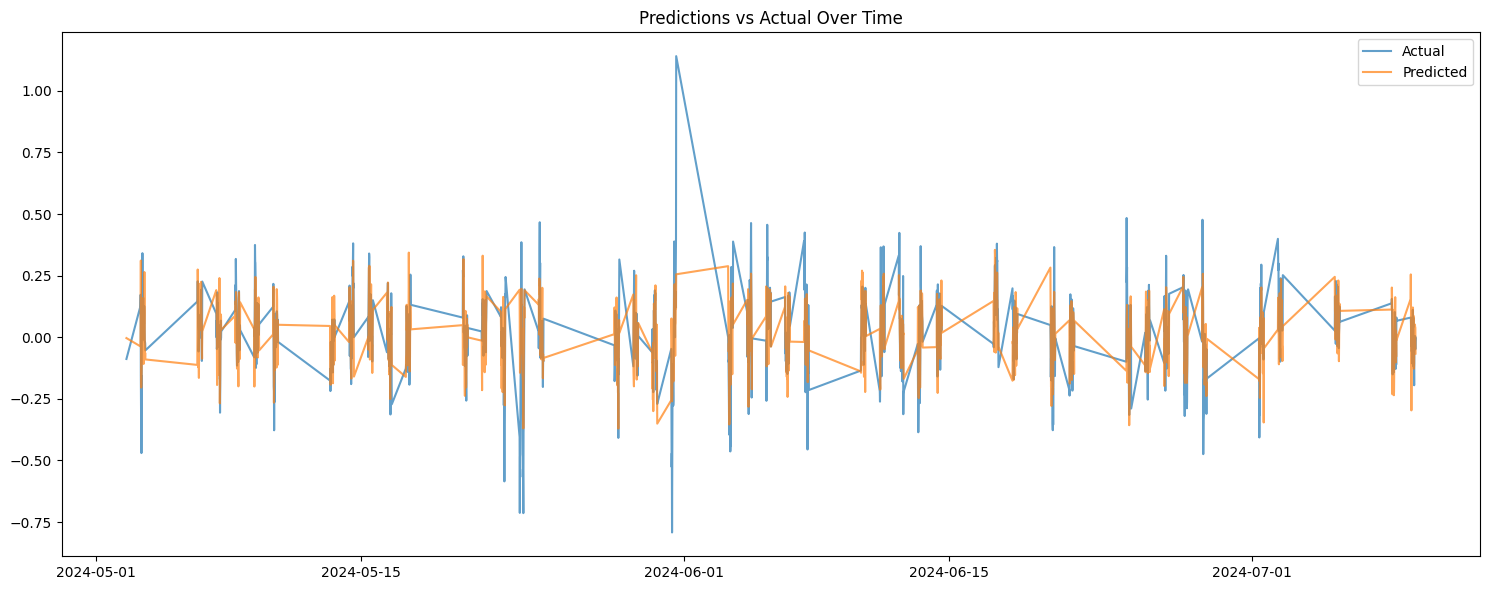

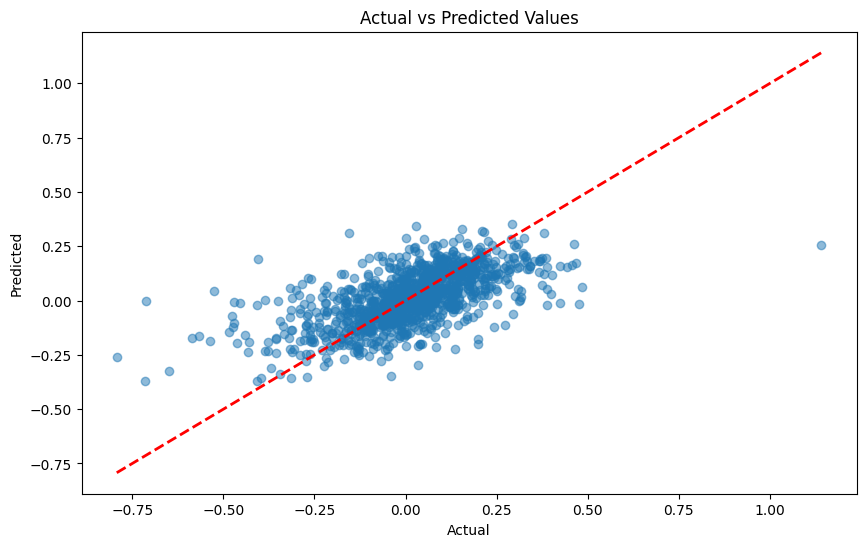

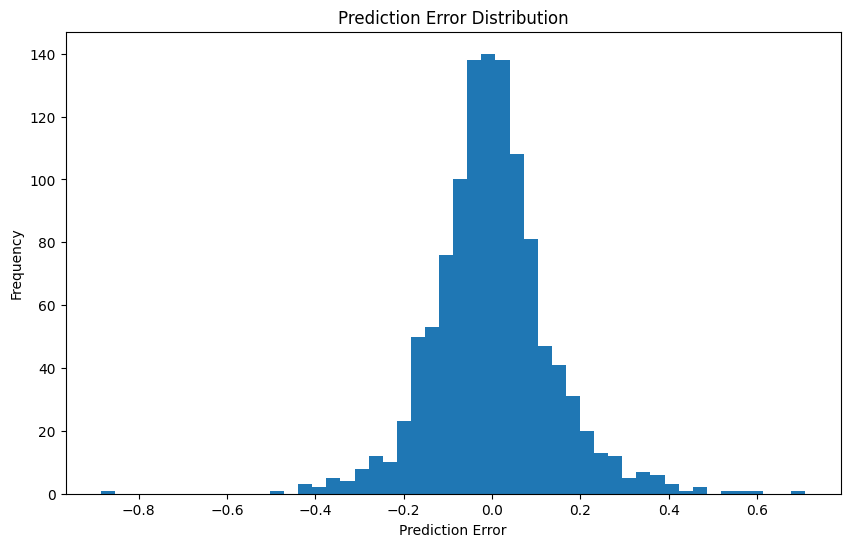


Direction Hit Rate: 74.15%


In [3]:
# Load data
df = pd.read_csv('model_data.csv', parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

# Initialize predictor with 5-day window
predictor = RollingWindowPredictor(window_size=5)

# Split data for training
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print("Training model...")
best_score = predictor.train(train_df, n_trials=5)
print(f"\nBest validation RMSE: {best_score:.4f}")

print("\nPerforming backtest on test set...")
results = predictor.evaluate(test_df)

# Calculate hit rate (direction prediction accuracy)
actual_direction = np.sign(results['actual'])
pred_direction = np.sign(results['predicted'])
hit_rate = np.mean(actual_direction == pred_direction)
print(f"\nDirection Hit Rate: {hit_rate:.2%}")

In [ ]:
# Calculate hit rate (direction prediction accuracy)
actual_direction = np.sign(results['actual'])
pred_direction = np.sign(results['predicted'])
hit_rate = np.mean(actual_direction == pred_direction)
print(f"\nDirection Hit Rate: {hit_rate:.2%}")